In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from noise2noise.training import *
from noise2noise.unet_resnet import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

training_img, training_target = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))
input_transform = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])

target_transform = transforms.Compose([ToFloatImage()])

In [ ]:
train_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

test_loader =  DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', transform=input_transform, target_transform=target_transform),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


In [ ]:
def freeze_encoder(resNet_unet):
  for p in resNet_unet.encoder.parameters():
    p.requires_grad = False

def unfreeze_encoder(resNet_unet):
  for p in resNet_unet.encoder.parameters():
    p.requires_grad = True

100%|██████████| 1000/1000 [00:35<00:00, 28.49it/s]


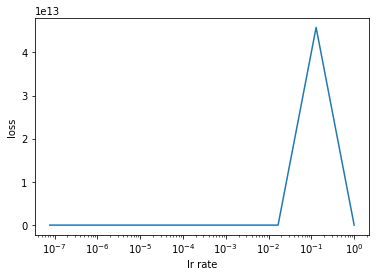

In [ ]:
unet = ResNetUnet().to(device)
freeze_encoder(unet)
metric = psnr_metric()
criterion = nn.MSELoss()

lr_finder(unet, train_loader, Adam, criterion, gradient_steps=1000, samples_steps=100)

In [ ]:
unet = ResNetUnet().to(device)
freeze_encoder(unet)
optim = Adam(unet.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=2e-3, total_steps=2000)

metric = psnr_metric()
criterion = nn.MSELoss()




train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 2000/2000 [01:20<00:00, 24.97it/s]


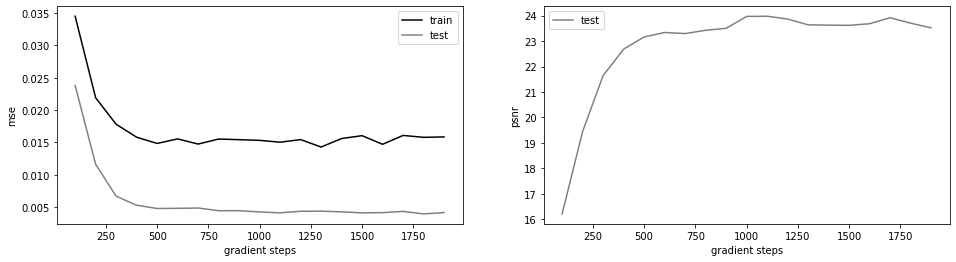

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :26.59895133972168
psnr :23.040340423583984
psnr :22.14546012878418
psnr :26.347780227661133


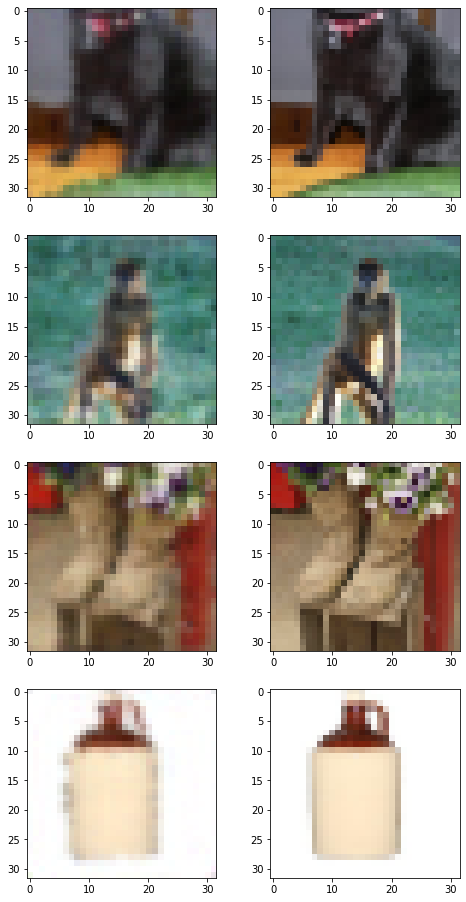

In [ ]:
show_results(unet, test_loader)

In [ ]:
unfreeze_encoder(unet)
optim = Adam(unet.parameters(), lr=3e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=3e-4, total_steps=2000)

train_loss, test_loss, test_metric = train(unet, 
                                           train_loader, 
                                           test_loader, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=2000, 
                                           samples_steps=100,
                                           lr_scheduler=scheduler,
                                           lr_steps=1)

100%|██████████| 2000/2000 [01:51<00:00, 17.89it/s]


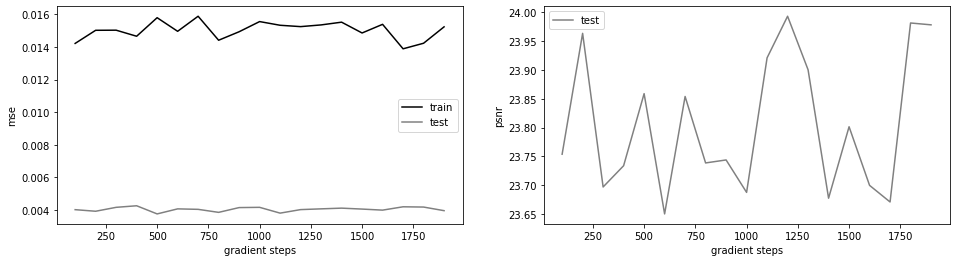

In [ ]:
plot_losses(train_loss, test_loss, test_metric)

psnr :26.509174346923828
psnr :21.26267433166504
psnr :21.13398551940918
psnr :20.077064514160156


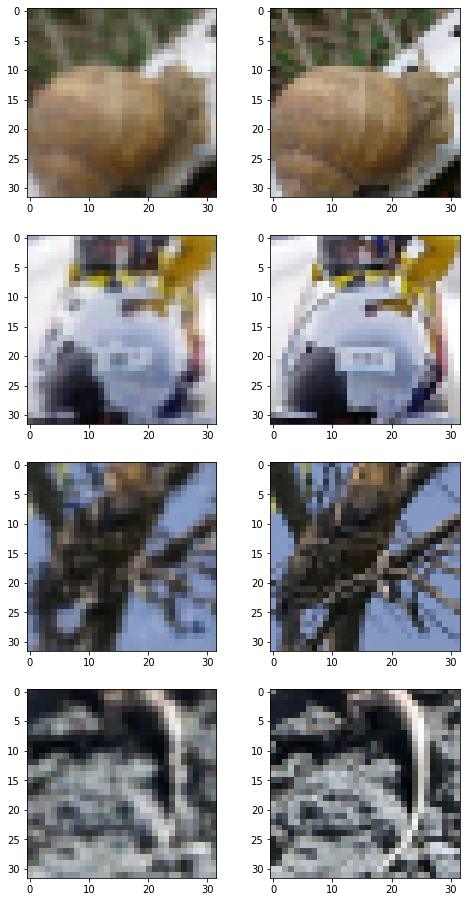

In [ ]:
show_results(unet, test_loader)